In [19]:
import pandas as pd
import numpy as np

import seaborn as sns

In [37]:
df = pd.read_csv('events_World_Cup.csv')
#df = pd.read_csv('germany.csv')
teams = pd.read_json('Wyscout/Teams/teams.json')

In [21]:
nat_teams = teams[teams.type == 'national']
nat_teams #ver id de las selecciones

,city,name,wyId,officialName,area,type
98,Seoul,Korea Republic,14855,Korea Republic,"{'name': 'Korea Republic', 'id': 410, 'alpha3c...",national
99,Budapest,Hungary,10451,Hungary,"{'name': 'Hungary', 'id': 348, 'alpha3code': '...",national
100,Istanbul,Turkey,4687,Turkey,"{'name': 'Turkey', 'id': 792, 'alpha3code': 'T...",national
101,Moskva,Russia,14358,Russia,"{'name': 'Russia', 'id': 643, 'alpha3code': 'R...",national
102,Solna,Sweden,7047,Sweden,"{'name': 'Sweden', 'id': 752, 'alpha3code': 'S...",national
103,El Menzah,Tunisia,16276,Tunisia,"{'name': 'Tunisia', 'id': 788, 'alpha3code': '...",national
104,"Rio de Janeiro, Rio de Janeiro",Brazil,6380,Brazil,"{'name': 'Brazil', 'id': 76, 'alpha3code': 'BR...",national
105,Frankfurt am Main,Germany,3148,Germany,"{'name': 'Germany', 'id': 276, 'alpha3code': '...",national
106,Tiran\u00eb (Tirana),Albania,8731,Albania,"{'name': 'Albania', 'id': 8, 'alpha3code': 'AL...",national
107,Bucure\u015fti,Romania,11944,Romania,"{'name': 'Romania', 'id': 642, 'alpha3code': '...",national


In [38]:
def separar_jugadas_2(df):

  team1 = df.teamId.unique()[0]
  team2 = df.teamId.unique()[1]

  #eliminar eventos que no queremos

  df1 = df.drop(df[(df['tag_0'] == 701) | # quitar duelos perdidos. Parece que solo aparecen en los 
                  (df['tag_1'] == 701) |
                  (df['tag_2'] == 701) |
                  (df['tag_3'] == 701) |
                  (df['tag_4'] == 701) |
                  (df['tag_5'] == 701)].index)
  
  df1 = df1.drop(df1[((df1['eventName'] == 'Duel') & (df1['teamId'].shift(-1) == df1['teamId'].shift(1)))].index) #Team - Duel - Team

     
  df1 = df1[(df1['eventName'] != "Save attempt")]

  df1['playId'] = ( ((df1['teamId'] != df1['teamId'].shift(2)) &  ((df1['teamId'] != df1['teamId'].shift(1))) |  #No las cuenta si alguna de las últimas 2 acciones son del otro equipo
                       (df1['eventName'].shift(1) == 'Interruption') | #sumar si el evento pasado es un interruption
                       (df1['matchPeriod'].shift(1) != df1['matchPeriod']) | #Asegura que en la transn 1H-2H se genere nueva jugada 
                       (df1['eventName'] == 'Free Kick') #Asegurar que los tiros libres inicien una nueva jugada
                       )).cumsum()                     

  (df1.loc[
      ((df1['teamId'] != df1['teamId'].shift(1)) & 
       (df1['teamId'] != df1['teamId'].shift(-1))),'playId']) = 0
    
  df['playId'] = (pd.concat((df,df1['playId']),axis=1))['playId'].fillna(0)

  return df

In [39]:
jug_sep = separar_jugadas_2(df)

In [24]:
jug_sep

,Unnamed: 0,eventId,subEventName,playerId,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,...,y_inicio,x_fin,y_fin,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,playId
0,0,8,Simple pass,122671,2057954,Pass,16521,1H,1.656214,85.0,...,50,35.0,53.0,1801.0,NaN,NaN,NaN,NaN,NaN,1.0
1,1,8,High pass,139393,2057954,Pass,16521,1H,4.487814,83.0,...,53,75.0,19.0,1801.0,NaN,NaN,NaN,NaN,NaN,1.0
2,2,1,Air duel,103668,2057954,Duel,14358,1H,5.937411,10.0,...,81,37.0,83.0,703.0,1801.0,NaN,NaN,NaN,NaN,0.0
3,3,1,Air duel,122940,2057954,Duel,16521,1H,6.406961,10.0,...,19,63.0,17.0,701.0,1802.0,NaN,NaN,NaN,NaN,0.0
4,4,8,Simple pass,122847,2057954,Pass,16521,1H,8.562167,85.0,...,17,71.0,15.0,1801.0,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,101754,8,Simple pass,3476,2058017,Pass,9598,2H,2978.301867,85.0,...,20,64.0,6.0,1801.0,NaN,NaN,NaN,NaN,NaN,17996.0
101755,101755,7,Touch,14812,2058017,Others on the ball,9598,2H,2979.084611,72.0,...,6,82.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,17996.0
101756,101756,8,Cross,14812,2058017,Pass,9598,2H,2983.448628,80.0,...,2,100.0,100.0,401.0,801.0,1802.0,NaN,NaN,NaN,17996.0
101757,101757,4,Goalkeeper leaving line,25381,2058017,Goalkeeper leaving line,4418,2H,2985.869275,40.0,...,0,18.0,98.0,NaN,NaN,NaN,NaN,NaN,NaN,17997.0


<AxesSubplot:xlabel='x_inicio', ylabel='y_inicio'>

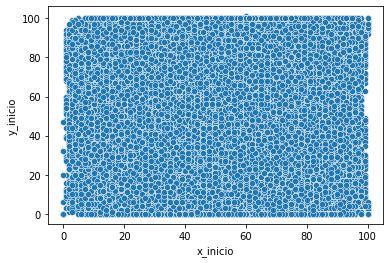

In [25]:
#ver posiciones de inicio de las jugadas, sin alguna transformación

sns.scatterplot(data=jug_sep, x="x_inicio", y="y_inicio")

<AxesSubplot:xlabel='x_inicio', ylabel='y_inicio'>

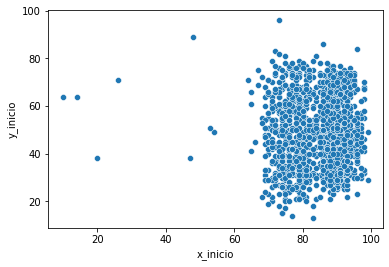

In [40]:
# ver los tiros

tiros = jug_sep[jug_sep['eventName'] == 'Shot']

sns.scatterplot(data=tiros, x="x_inicio", y="y_inicio")

# Transformar coordenadas

In [41]:
# crear df de los partidos y cada equipo 

norm1 = jug_sep.copy()

norm1.groupby(['matchId','teamId']).count().columns
df2 = jug_sep[['matchId','teamId','x_inicio']]

df2 = jug_sep.groupby(['matchId','teamId']).size().reset_index().rename(columns={0:'count'})
df2['team2'] = df2['teamId'].shift(-1)
df2['match2'] = df2['matchId'].shift(-1)
df2['same_match'] = df2['matchId']-df2['match2']

df2.loc[df2.same_match == -1, "team2"] = df2.teamId
df2.dropna(subset = ['same_match'], inplace=True)


df2 = df2[df2['teamId'] != df2['team2']]
df2['team1'] = df2['teamId']
df2 = df2.drop(columns=['teamId'])

df2

,matchId,count,team2,match2,same_match,team1
0,2057954,680,16521.0,2057954.0,0.0,14358
2,2057955,953,16129.0,2057955.0,0.0,15670
4,2057956,812,16129.0,2057956.0,0.0,14358
6,2057957,776,16521.0,2057957.0,0.0,15670
8,2057958,655,15670.0,2057958.0,0.0,14358
...,...,...,...,...,...,...
118,2058013,826,7047.0,2058013.0,0.0,2413
120,2058014,653,5629.0,2058014.0,0.0,4418
122,2058015,907,9598.0,2058015.0,0.0,2413
124,2058016,897,5629.0,2058016.0,0.0,2413


In [42]:
#importante
#crear la columna is_home

frames = [jug_sep,df2]

result = pd.merge(jug_sep,df2, how="left", on="matchId")
result = result.drop(columns=['same_match'])
result['is_home'] = result['teamId']-result['team1'] #si no es 0, es local


result

,Unnamed: 0,eventId,subEventName,playerId,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,...,tag_2,tag_3,tag_4,tag_5,playId,count,team2,match2,team1,is_home
0,0,8,Simple pass,122671,2057954,Pass,16521,1H,1.656214,85.0,...,NaN,NaN,NaN,NaN,1.0,680,16521.0,2057954.0,14358,2163
1,1,8,High pass,139393,2057954,Pass,16521,1H,4.487814,83.0,...,NaN,NaN,NaN,NaN,1.0,680,16521.0,2057954.0,14358,2163
2,2,1,Air duel,103668,2057954,Duel,14358,1H,5.937411,10.0,...,NaN,NaN,NaN,NaN,0.0,680,16521.0,2057954.0,14358,0
3,3,1,Air duel,122940,2057954,Duel,16521,1H,6.406961,10.0,...,NaN,NaN,NaN,NaN,0.0,680,16521.0,2057954.0,14358,2163
4,4,8,Simple pass,122847,2057954,Pass,16521,1H,8.562167,85.0,...,NaN,NaN,NaN,NaN,1.0,680,16521.0,2057954.0,14358,2163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,101754,8,Simple pass,3476,2058017,Pass,9598,2H,2978.301867,85.0,...,NaN,NaN,NaN,NaN,17996.0,601,9598.0,2058017.0,4418,5180
101755,101755,7,Touch,14812,2058017,Others on the ball,9598,2H,2979.084611,72.0,...,NaN,NaN,NaN,NaN,17996.0,601,9598.0,2058017.0,4418,5180
101756,101756,8,Cross,14812,2058017,Pass,9598,2H,2983.448628,80.0,...,1802.0,NaN,NaN,NaN,17996.0,601,9598.0,2058017.0,4418,5180
101757,101757,4,Goalkeeper leaving line,25381,2058017,Goalkeeper leaving line,4418,2H,2985.869275,40.0,...,NaN,NaN,NaN,NaN,17997.0,601,9598.0,2058017.0,4418,0


In [47]:
#ya transformar los datos


norm1 = result

norm1['x_inic_norm']  = result.x_inicio
norm1['y_inic_norm'] = result.y_inicio
norm1['x_fin_norm'] = result.x_fin
norm1['y_fin_norm'] = result.y_fin

norm1['x_inic_norm'] = result.loc[result.is_home != 0, "x_inicio"] = 100-result.x_inicio
#norm1['y_inic_norm'] = result.loc[result.is_home != 0, "y_inicio"] = 100-result.y_inicio
norm1['x_fin_norm'] = result.loc[result.is_home != 0, "x_fin"] = 100-result.x_fin
#norm1['y_fin_norm'] = result.loc[result.is_home != 0, "y_fin"] = 100-result.y_fin


#norm1[['teamId','matchId','x_inicio','x_inic_norm','y_inicio','y_inic_norm','is_home']]

#para los del mundial tenía que correr el siguiente bloque 

#ojo: luego hay que cambiar todo lo de '2H'. Si no estárían al revés. en 1h todos de izq a der y en 2h de der a izq
norm1['x_inic_norm'] = result.loc[result.matchPeriod != '1H', "x_inic_norm"] = 100-result.x_inicio
#norm1['y_inic_norm'] = result.loc[result.is_home != 0, "y_inicio"] = 100-result.y_inicio
norm1['x_fin_norm'] = result.loc[result.matchPeriod != '1H', "x_fin"] = 100-result.x_fin
#norm1['y_fin_norm'] = result.loc[result.is_home != 0, "y_fin"] = 100-result.y_fin

<AxesSubplot:xlabel='x_inic_norm', ylabel='y_inicio'>

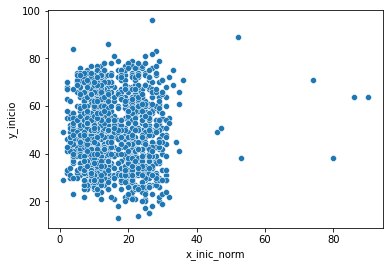

In [48]:
# ver los tiros

tiros_norm = norm1[norm1['eventName'] == 'Shot']

sns.scatterplot(data=tiros_norm, x="x_inic_norm", y="y_inicio")

In [31]:
#
norm1.to_csv('norm1.csv')

In [32]:
#tiros de toso el partido

<AxesSubplot:xlabel='x_inic_norm', ylabel='y_inicio'>

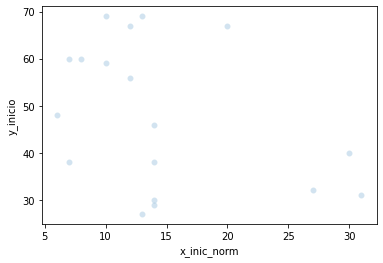

In [33]:
#probar si se transformó bien

#si se transformó bien
#habría que verificar que se volteó siempre el del mismo lado
data_prueba = norm1[ (norm1['matchId'] == 2057954) 
                   & (norm1['eventName'] == 'Shot')]

#sns.scatterplot(data=data_prueba, x="x_inicio", y="y_inicio", alpha=0.1)
sns.scatterplot(data=data_prueba, x="x_inic_norm", y="y_inicio", alpha=0.2)

(array([[0., 1., 0., 3., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 3., 1., 2.,
         0., 3.],
        [3., 1., 2., 4., 4., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]]),
 array([ 6.  ,  7.76,  9.52, 11.28, 13.04, 14.8 , 16.56, 18.32, 20.08,
        21.84, 23.6 , 25.36, 27.12, 28.88, 30.64, 32.4 , 34.16, 35.92,
        37.68, 39.44, 41.2 , 42.96, 44.72, 46.48, 48.24, 50.  , 51.76,
        53.52, 55.28, 57.04, 58.8 , 60.56, 62.32, 64.08, 65.84, 67.6 ,
        69.36, 71.12, 72.88, 74.64, 76.4 , 78.16, 79.92, 81.68, 83.44,
        85.2 , 86.96, 88.72, 90.48, 92.24, 94.  ]),
 <a list of 2 BarContainer objects>)

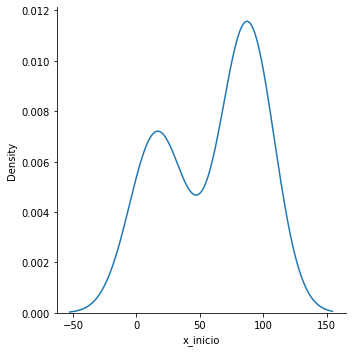

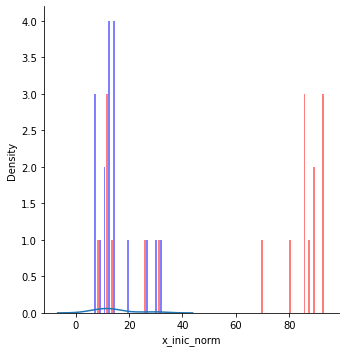

In [34]:
import matplotlib.pyplot as plt

sns.displot(data_prueba, x="x_inicio", kind="kde")
sns.displot(data_prueba, x="x_inic_norm", kind="kde")

x_inicio = data_prueba['x_inicio']
x_norm = data_prueba['x_inic_norm']

plt.hist([x_inicio, x_norm], color=['r','b'], alpha=0.5, bins=50)


In [35]:
#cambiar todos los de 2H

## Regresión logística

In [36]:
# preparar datos para reresión logística

jug_sep.loc[jug_sep['eventName'] == 'Shot', 'is_shot'] = 1
jug_sep['is_shot'].unique()
jug_sep['y'] = jug_sep['is_shot'].fillna(0)

data_final = jug_sep[['x_inicio','y_inicio','x_fin','y_fin','y']]

data_final = data_final.dropna() # hay registros que no tienen coordenadas registradas
#vale la pena ver que eventos son y si hay una razón 

data_final #101759 originalmente

,x_inicio,y_inicio,x_fin,y_fin,y
0,50,50,35.0,53.0,0.0
1,35,53,75.0,19.0,0.0
2,25,81,37.0,83.0,0.0
3,75,19,63.0,17.0,0.0
4,63,17,71.0,15.0,0.0
...,...,...,...,...,...
101754,46,20,64.0,6.0,0.0
101755,64,6,82.0,2.0,0.0
101756,82,2,100.0,100.0,0.0
101757,0,0,18.0,98.0,0.0
